Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [38]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
obspack_filenames = [ # now including aircraft
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
]

obspack_files = {}
for f in obspack_filenames:
    stn = os.path.basename(f).split('_')[1]
    obspack_files[stn] = os.path.basename(f)

### Contribution details
- 15 Obspack netcdf files (e.g. nicam-tm_gl5_mlo_surface-flask_4_representative.nc) each with all 10 tracers
    - no 'time', just 'time_components' and 'time_decimal'
- including 3 ship files in ObsPack format
- including full ObsPack (one netcdf file per year)
- including 3-hourly output at fixed sites

In [39]:
droot = "/glade/p/eol/stephens/longcoll/apo-simulation-data/NICAM/primary_data"

station_list = ['cba']

station_records = {}
for station in station_list:

    path = f"{droot}/{obspack_files[station].replace('co2_','nicam-tm_gl5_')}"
    
    print(path)
    ds = xr.open_dataset(path)

    # no variable 'time' - recreate from time_components
    tc = ds['time_components']
    tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
    tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
    ds['time'] = pd.to_datetime(tc)

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})
    
    ds.to_netcdf(f"inverse_model_obspack_files/NICAM/{obspack_files[station]}")
    
    station_records[station] = ds
    
    
station_list = ['psa']

station_records = {}
for station in station_list:

    path = f"{droot}/{obspack_files[station].replace('co2_','nicam-tm_gl5_')}"
    
    print(path)
    ds2 = xr.open_dataset(path)

    # no variable 'time' - recreate from time_components
    tc = ds2['time_components']
    tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
    tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
    ds2['time'] = pd.to_datetime(tc)

    # get time as coordinate
    time = ds2.time
    time.name = 'obs'
    ds2['obs'] = time
    ds2 = ds2.drop('time').rename({'obs': 'time'})
    
    ds2.to_netcdf(f"inverse_model_obspack_files/NICAM/{obspack_files[station]}")
    
    station_records[station] = ds2

/glade/p/eol/stephens/longcoll/apo-simulation-data/NICAM/primary_data/nicam-tm_gl5_cba_surface-flask_4_representative.nc
/glade/p/eol/stephens/longcoll/apo-simulation-data/NICAM/primary_data/nicam-tm_gl5_psa_surface-flask_4_representative.nc


In [40]:
ds.encoding['missing_value'] = -999999
ds.to_netcdf('temp.nc')
tmp=xr.open_dataset('temp.nc')
tmp['apo_jena']

<xarray.DataArray 'apo_jena' (time: 553)>
array([-9.999990e+05, -9.999990e+05, -9.999990e+05, ...,  2.672405e+00,
       -2.735962e+00, -3.539392e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1995-08-16T20:30:00 ... 2020-12-03T22:40:00
Attributes:
    units:    dry air mole fraction 10^-6 mol/mol (ppm)
    comment:  simulated values

In [41]:
# add derived APO variables

ds['apo_cesm'] = util.compute_apo (
    o2=ds['o2_cesm'],
    co2=ds['co2_cesm'],
    n2=ds['n2_cesm']
)

ds['apo_diss'] = util.compute_apo (
    o2=ds['o2_gk01r16'],
    co2=ds['co2_somffn'],
    n2=ds['n2_era']
)

ds['apo_gridfed'] = util.compute_apo (
    o2=ds['o2_gridfed'],
    co2=ds['co2_gridfed'],
    n2=0.0
)

ds['apo_oco2mip'] = util.compute_apo (
    o2=ds['co2_oco2mip'] * -1.4,
    co2=ds['co2_oco2mip'],
    n2=0.0
)

# kluge - need to make station name dynamic and allow any number of stations
ds2['apo_cesm'] = util.compute_apo (
    o2=ds2['o2_cesm'],
    co2=ds2['co2_cesm'],
    n2=ds2['n2_cesm']
)

ds2['apo_diss'] = util.compute_apo (
    o2=ds2['o2_gk01r16'],
    co2=ds2['co2_somffn'],
    n2=ds2['n2_era']
)

ds2['apo_gridfed'] = util.compute_apo (
    o2=ds2['o2_gridfed'],
    co2=ds2['co2_gridfed'],
    n2=0.0
)

ds2['apo_oco2mip'] = util.compute_apo (
    o2=ds2['co2_oco2mip'] * -1.4,
    co2=ds2['co2_oco2mip'],
    n2=0.0
)

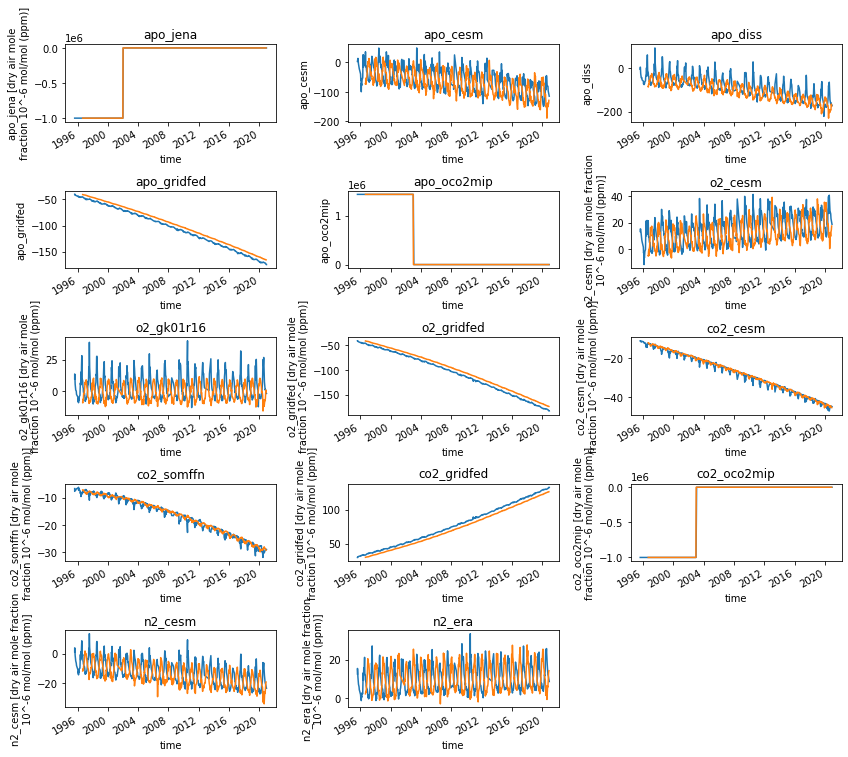

In [42]:
sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    ds[v].plot(ax=ax)
    ds2[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

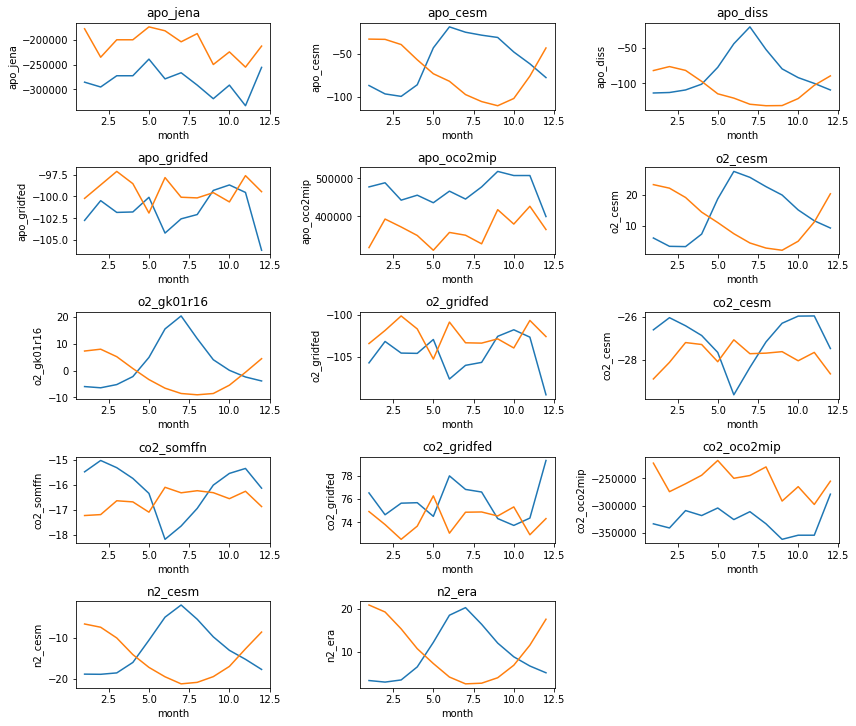

In [43]:
# seasonal climatology
ds_seas=ds.groupby('time.month').mean('time')
ds_seas['apo_cesm']

# kluge - need to make station name dynamic and allow any number of stations
ds2_seas=ds2.groupby('time.month').mean('time')
ds2_seas['apo_cesm']

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    ds_seas[v].plot(ax=ax)
    ds2_seas[v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    